## Introduction to convnets

Let's start by creating a simple covnets for MNIST digit dataset.

In [1]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of
shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of channels is controlled by the first
argument passed to the Conv2D layers (32 or 64).
The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely
connected classifier network: a stack of Dense
layers. These classifiers process vectors, which are 1D, whereas the current output is a
3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

As you can see, the (3, 3, 64) outputs are flattened into vectors of shape (576,)
before going through two Dense layers.

Now, let’s train the convnet on the MNIST digits. 

In [8]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [13]:
model.compile(optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 38s 34ms/step - loss: 0.0158 - accuracy: 0.9954
Epoch 2/5
938/938 [==============================] - 31s 33ms/step - loss: 0.0118 - accuracy: 0.9964
Epoch 3/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0089 - accuracy: 0.9969
Epoch 4/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0082 - accuracy: 0.9975
Epoch 5/5
938/938 [==============================] - 37s 39ms/step - loss: 0.0070 - accuracy: 0.9979


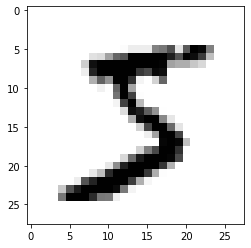

In [15]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0], cmap=plt.cm.binary)

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 6s 6ms/step - loss: 0.0347 - accuracy: 0.9917


In [11]:
test_acc

0.9896000027656555

About 99% of accuracy, even for this simple model!

But why does this simple convnet work so well, compared to a densely connected
model? To answer this, let’s dive into what the `Conv2D` and `MaxPooling2D` layers do.

### The convolution operation

The fundamental difference between a densely connected layer and a convolution
layer is this: `Dense` layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn
local patterns: in the case of images, patterns found in small 2D windows of the inputs. In the previous example, these windows were all 3 × 3.

![](img/04_01.png)

This key characteristic gives convnets two interesting properties:
* *The patterns they learn are translation invariant*: After learning a certain pattern in
the lower-right corner of a picture, a convnet can recognize it anywhere: for
example, in the upper-left corner. A densely connected network would have to
learn the pattern anew if it appeared at a new location.
* *They can learn spatial hierarchies of patterns*: A first convolution layer
will learn small local patterns such as edges, a second convolution layer will
learn larger patterns made of the features of the first layers, and so on. This
allows convnets to efficiently learn increasingly complex and abstract visual concepts

![](img/04_02.png "Hierarchical feature maps")

Convolutions operate over 3D tensors, called *feature maps*, with two spatial axes (height
and width) as well as a depth axis (also called the channels axis). The convolution operation extracts patches from its input feature
map and applies the same transformation to all of these patches, producing an output
feature map. This output feature map is still a 3D tensor: it has a width and a height. Its
depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB
input; rather, they stand for filters. Filters encode specific aspects of the input data: at a
high level, a single filter could encode the concept “presence of a face in the input,”
for instance.

In the MNIST example, the first convolution layer takes a feature map of size (28,
28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its
input. Each of these 32 output channels contains a 26 × 26 grid of values, which is a
response map of the filter over the input, indicating the response of that filter pattern at
different locations in the input.

![](img/04_03.png)

Convolutions are defined by two key parameters:
* *Size of the patches extracted from the inputs*—These are typically 3 × 3 or 5 × 5. In the
example, they were 3 × 3, which is a common choice.
* *Depth of the output feature map*—The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the 3D input
feature map, stopping at every possible location, and extracting the 3D patch of surrounding features (shape (window_height, window_width, input_depth)). Each
such 3D patch is then transformed (via a tensor product with the same learned weight
matrix, called the convolution kernel) into a 1D vector of shape (output_depth,). All of
these vectors are then spatially reassembled into a 3D output map of shape (height,
width, output_depth). Every spatial location in the output feature map corresponds
to the same location in the input feature map (for example, the lower-right corner of
the output contains information about the lower-right corner of the input). For
instance, with 3 × 3 windows, the vector output[i, j, :] comes from the 3D patch
input[i-1:i+1, j-1:j+1, :]

#### UNDERSTANDING BORDER EFFECTS AND PADDING

Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you
can center a 3 × 3 window, forming a 3 × 3 grid. Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension,
in this case.

![](img/04_04.png "Valid locations of 3 × 3 patches in a 5 × 5 input feature map")

If you want to get an output feature map with the same spatial dimensions as the
input, you can use padding. Padding consists of adding an appropriate number of rows
and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile

![](img/04_05.png "Padded input feature map")

In Conv2D layers, padding is configurable via the `padding` argument, which takes two
values: `"valid"`, which means no padding (only valid window locations will be used);
and `"same"`, which means “pad in such a way as to have an output with the same width
and height as the input.” 

#### UNDERSTANDING CONVOLUTION STRIDES

The distance between two successive windows is a parameter of the
convolution, called its stride, which defaults to 1. It’s possible to have strided convolutions: convolutions with a stride higher than 1. You can see the patches
extracted by a 3 × 3 convolution with stride 2 over a 5 × 5 input (without padding)

![](img/04_06.png "3 × 3 convolution patches with 2 × 2 strides")

### The max-pooling operation

Pooling layers are used as the purpose of gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network. Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It’s conceptually similar to convolution, except
that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation.